# imgseg

In [49]:
import pandas as pd
from sklearn import metrics
from scipy import interpolate
import numpy as np
import os
import csv
import collections
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from pyod.models.loda import LODA
from pyod.models.lscp import LSCP
from sklearn.datasets import make_classification
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import precision_n_scores
import time
from sklearn.metrics import roc_auc_score

### 获取异常点比例

In [2]:
data = pd.read_csv('data/imgseg/meta_data/meta_imgseg.csv')

In [3]:
ar = data['anomaly.rate']
ar_level = data['anomaly.rate.level']

In [4]:
set(ar_level)

{'ar-0', 'ar-1', 'ar-2', 'ar-3', 'ar-4', 'ar-6'}

In [5]:
data_dic = collections.defaultdict(list)
for item in data.iterrows():
    data_dic[item[1]['anomaly.rate.level']].append(item[1]['bench.id'])
for item in data_dic:
    print(len(data_dic[item]))

120
120
120
120
120
120


In [96]:
ar_mean = [np.mean(ar[:120]), np.mean(ar[120:240]), np.mean(ar[240:360]),
           np.mean(ar[360:480]), np.mean(ar[480:600]), np.mean(ar[600:720])]

In [97]:
ar_mean

[0.4281092436974788,
 0.001685838003032082,
 0.005040141475648629,
 0.010003968253968262,
 0.05035971223021575,
 0.09999999999999978]

### 可以看到，数据集一共分为6个异常点比例等级，个数均为120，异常点平均比例如上

In [6]:
data = pd.read_csv('data/imgseg/benchmarks/imgseg_benchmark_0001.csv')

### 观察其中一个csv数据，选择特征属性

In [7]:
data.head(5)

,point.id,motherset,origin,original.label,diff.score,ground.truth,REGION.CENTROID.COL,REGION.CENTROID.ROW,SHORT.LINE.DENSITY.5,SHORT.LINE.DENSITY.2,...,INTENSITY.MEAN,RAWRED.MEAN,RAWBLUE.MEAN,RAWGREEN.MEAN,EXRED.MEAN,EXBLUE.MEAN,EXGREEN.MEAN,VALUE.MEAN,SATURATION.MEAN,HUE.MEAN
0,imgseg_point_2056,imgseg,multiclass,BRICKFACE,0.000129,nominal,0.974363,0.097117,-0.35697,-0.19451,...,-0.804640,-0.711607,-0.846696,-0.835089,1.498462,-0.940579,0.091011,-0.860059,0.495952,0.278331
1,imgseg_point_0348,imgseg,multiclass,WINDOW,0.002989,anomaly,0.851002,-1.520728,-0.35697,-0.19451,...,-0.773595,-0.800403,-0.716510,-0.807590,0.385774,-0.253651,0.042918,-0.748745,0.971331,-0.475234
2,imgseg_point_1699,imgseg,multiclass,FOLIAGE,0.000577,nominal,-0.259248,0.218891,-0.35697,-0.19451,...,-0.952103,-0.933596,-0.971777,-0.935919,0.942118,-0.912194,0.600799,-1.007614,2.347998,-0.473359
3,imgseg_point_2160,imgseg,multiclass,SKY,0.004510,anomaly,0.206783,-1.555521,-0.35697,-0.19451,...,1.792465,1.666846,1.910184,1.752886,-2.597381,2.255626,-1.217126,1.915016,-0.627958,-0.597760
4,imgseg_point_1577,imgseg,multiclass,GRASS,0.001177,nominal,0.289023,1.993302,-0.35697,-0.19451,...,-0.504862,-0.508646,-0.634825,-0.340104,0.376182,-1.281205,1.793512,-0.544239,-0.488974,2.394541


In [9]:
data.columns

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'REGION.CENTROID.COL', 'REGION.CENTROID.ROW',
       'SHORT.LINE.DENSITY.5', 'SHORT.LINE.DENSITY.2', 'VEDGE.MEAN',
       'VEDGE.SD', 'HEDGE.MEAN', 'HEDGE.SD', 'INTENSITY.MEAN', 'RAWRED.MEAN',
       'RAWBLUE.MEAN', 'RAWGREEN.MEAN', 'EXRED.MEAN', 'EXBLUE.MEAN',
       'EXGREEN.MEAN', 'VALUE.MEAN', 'SATURATION.MEAN', 'HUE.MEAN'],
      dtype='object')

### 选择groundtruth之后的属性为特征

### 定义评估函数

In [10]:
def evaluation(y, y_scores, method):
    '''
    评估函数，y为groundtruth，y_scores为预测值，返回PR曲线，ROC曲线和AUC
    '''
    if isinstance(y_scores, dict):
        colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
        plt.figure(figsize=(7,7))
        i = 0
        for algo in y_scores:
            pre_scr = y_scores[algo]
            print(algo, pre_scr.shape)
            fpr_level = np.arange(0, 1, 0.01)
            fpr, tpr, threshold = metrics.roc_curve(y, pre_scr)
            interp = interpolate.interp1d(fpr, tpr)
            tpr_at_fpr = [interp(x) for x in fpr_level]
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i], label='%s ROC(area = %0.2f)' % (algo, roc_auc))
            i += 1
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Models Compare' + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.legend(loc="lower right")
    else:
        fpr_level = np.arange(0, 1, 0.01)
        fpr, tpr, threshold = metrics.roc_curve(y, y_scores)
        interp = interpolate.interp1d(fpr, tpr)
        tpr_at_fpr = [interp(x) for x in fpr_level]
        roc_auc = metrics.auc(fpr, tpr)
        precision, recall, _ = metrics.precision_recall_curve(y, y_scores)
        pr_auc = round(precision_n_scores(y, y_scores), ndigits=4)
#         pr_auc_t = metrics.auc(recall, precision)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(method + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, marker='.', label='precision @ rank n: %0.2f)' % pr_auc)
        plt.legend(loc="upper right")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(method + '-PR')
        plt.show()

### 对原始数据集进行抽样，每一个异常点level选择一个benchmark，共6个benchmark进行拼接，并读取groundturth和特征属性

In [12]:
path = 'data/imgseg/benchmarks/'
samples = []
for item in data_dic:
    samples.append(data_dic[item][0])
y = []
x_train = []
contam = 0
for sample in samples:
    p = os.path.join(path, sample+'.csv')
    data = pd.read_csv(p)
    data = data.dropna()
    for i in data.iterrows():
        # 0为正常，1为异常点
        if i[1][5] == 'anomaly':
            y.append(1)
            contam += 1
        else:
            y.append(0)
        x_train.append(list(i[1][6:24]))
x_train = np.array(x_train)
y = np.array(y)
contam /= len(y)

In [13]:
contam

0.10292716133424099

### 使用算法在抽样集合中进行离群点检测，该部分用到的算法分别为Proximity-Based(KNN，LOF)，Linear Model(PCA)，Outlier Ensembles(LODA)，算法组合（PCA+KNN）

In [14]:
algorithms = ['KNN', 'LOF', 'PCA', 'LODA']
all_scores = {}
# all_scores = collections.defaultdict(list)

### 首先对比分析算法在同一个benchmark上的表现，这里我们选择抽样的6个数据集进行测试

### 1.KNN

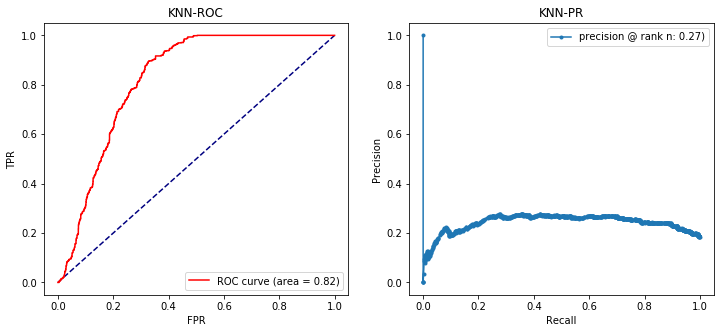

In [15]:
clf_name = 'KNN'
clf = KNN(n_neighbors=5, contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
knn_y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
knn_y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, knn_y_scores, clf_name)
all_scores['KNN'] = knn_y_scores

### 2.LOF

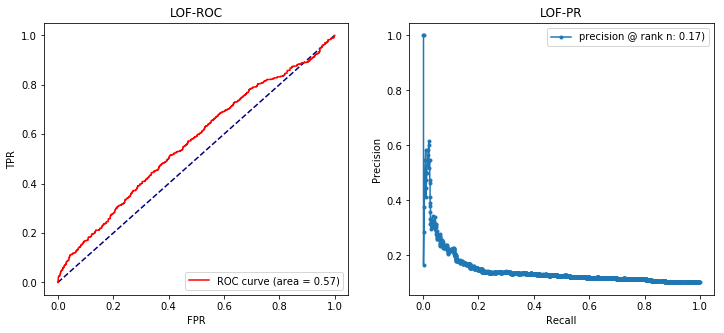

In [27]:
clf_name = 'LOF'
clf = LOF(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, y_scores, clf_name)
all_scores['LOF'] = y_scores 

### 3.PCA

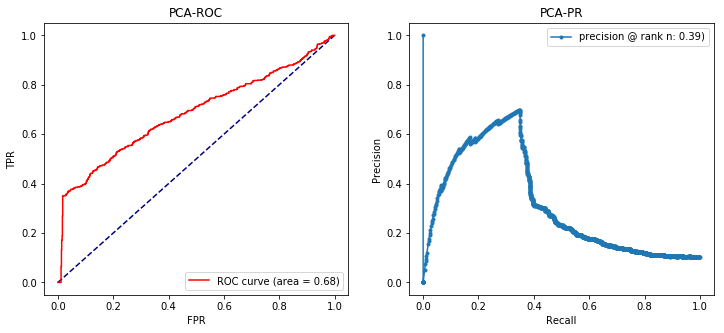

In [17]:
clf_name = 'PCA'
clf = PCA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, y_scores, clf_name)
all_scores['PCA'] = y_scores 

### 4.LODA

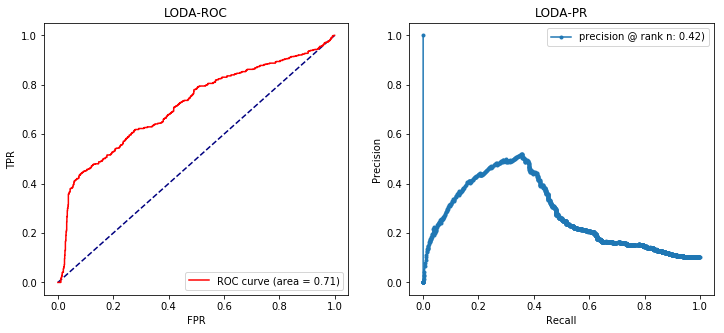

In [22]:
clf_name = 'LODA'
clf = LODA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, y_scores, clf_name)
all_scores['LODA'] = y_scores 

### 5.PCA+KNN

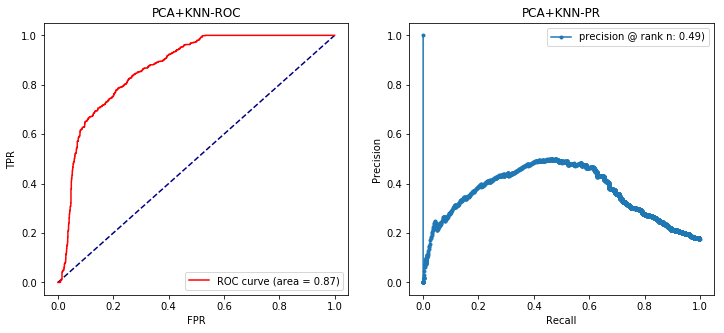

In [23]:
pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel="poly")
x_train_pca = kpca.fit_transform(x_train)
clf = KNN(n_neighbors=5, contamination=contam)
x_train_pca = standardizer(x_train_pca)
clf.fit(x_train_pca)
y_pred_pca = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, y_scores, 'PCA+KNN')
all_scores['PCA+KNN'] = y_scores 

KNN (7345,)
LOF (7345,)
PCA (7345,)
LODA (7345,)
PCA+KNN (7345,)


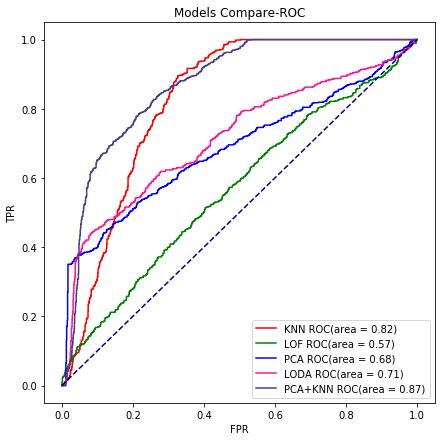

In [24]:
evaluation(y, all_scores, algorithms)

### 可以看到，在同一个抽样的benchmark下，PCA+KNN表现最好，ROC-AUC达到了0.87，LOF表现最差，仅有0.57

### 对PCA+KNN进行可视化

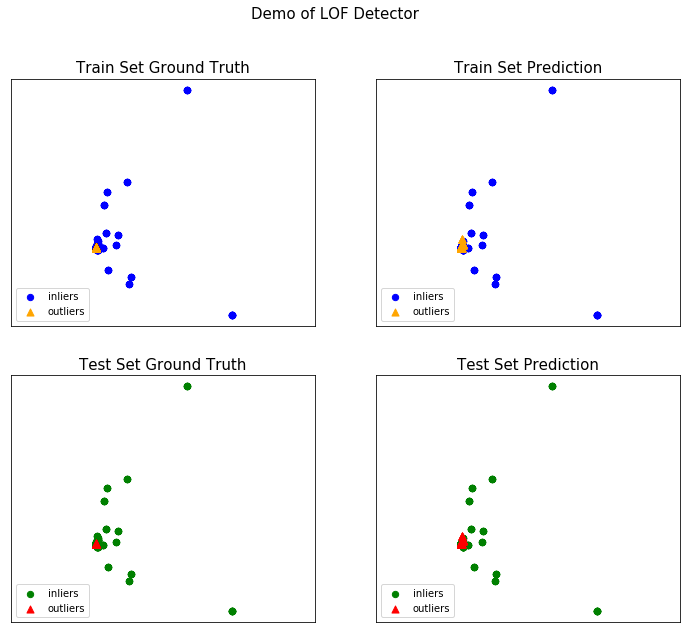

In [47]:
visualize(clf_name, x_train_pca, y, x_train_pca, y, y_pred, y_pred,
         show_figure=True, save_figure=False)

### 上图为可视化结果，由于没有test集，因此train和test的结果相同。可以看到，对原始11维数据进行PCA降维之后，数据之间的分布并没有改善，但算法还是很好的识别出了大部分正常点和异常点。集中分布的区域识别效果较差/

### 在所有样本上进行模型benchmark测试，输出auc到表格

In [68]:
results = collections.defaultdict(list)
with open('results_imgseg.csv', 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['benchmark_id', 'Model', 'ROC', 'precision at rank n', 'execution time'])
    for item in data_dic:
        for bench_id in data_dic[item]:
            x_item = []
            y_item = []
            contam = 0
            p = os.path.join(path, bench_id+'.csv')
            for i in pd.read_csv(p).iterrows():
                if i[1][5] == 'anomaly':
                    y_item.append(1)
                    contam += 1
                else:
                    y_item.append(0)
                x_item.append(list(i[1][6:17]))
            x_item = np.array(x_item)
            y_item = np.array(y_item)
            contam /= len(y_item)
            contam = min(0.5, contam)
            # 定义模型
            classifiers = {'KNN': KNN(contamination=contam),
                           'LOF': LOF(contamination=contam),
                           'PCA': PCA(contamination=contam),
                           'LODA': LODA(contamination=contam)
                          }
            for cls in classifiers:
                clf = classifiers[cls]
                t0 = time.time()
                x_item = standardizer(x_item)
                clf.fit(x_item)
                y_scores = clf.decision_function(x_item)
                t1 = time.time()
                duration = round(t1 - t0, ndigits=4)

                roc = round(roc_auc_score(y_item, y_scores), ndigits=4)
                prn = round(precision_n_scores(y_item, y_scores), ndigits=4)
                results[cls].append(roc)
                
                print('benchmark id:{bench_id}, model:{clf_name}, ROC:{roc}, precision @ rank n:{prn}, '
                      'execution time: {duration}s'.format(
                    bench_id=bench_id, clf_name=cls, roc=roc, prn=prn, duration=duration))

                csv_writer.writerow([bench_id, cls, roc, prn, duration])
            
f.close()

benchmark id:imgseg_benchmark_0001, model:KNN, ROC:0.472, precision @ rank n:0.4222, execution time: 0.0971s
benchmark id:imgseg_benchmark_0001, model:LOF, ROC:0.5082, precision @ rank n:0.4861, execution time: 0.047s
benchmark id:imgseg_benchmark_0001, model:PCA, ROC:0.649, precision @ rank n:0.5619, execution time: 0.003s
benchmark id:imgseg_benchmark_0001, model:LODA, ROC:0.6163, precision @ rank n:0.573, execution time: 0.021s
benchmark id:imgseg_benchmark_0002, model:KNN, ROC:0.504, precision @ rank n:0.411, execution time: 0.0991s
benchmark id:imgseg_benchmark_0002, model:LOF, ROC:0.5485, precision @ rank n:0.4609, execution time: 0.05s
benchmark id:imgseg_benchmark_0002, model:PCA, ROC:0.6371, precision @ rank n:0.5116, execution time: 0.003s
benchmark id:imgseg_benchmark_0002, model:LODA, ROC:0.6456, precision @ rank n:0.5433, execution time: 0.02s
benchmark id:imgseg_benchmark_0003, model:KNN, ROC:0.4846, precision @ rank n:0.4127, execution time: 0.1041s
benchmark id:imgseg_b

benchmark id:imgseg_benchmark_0020, model:KNN, ROC:0.501, precision @ rank n:0.4073, execution time: 0.1051s
benchmark id:imgseg_benchmark_0020, model:LOF, ROC:0.4973, precision @ rank n:0.4236, execution time: 0.0561s
benchmark id:imgseg_benchmark_0020, model:PCA, ROC:0.6556, precision @ rank n:0.5316, execution time: 0.003s
benchmark id:imgseg_benchmark_0020, model:LODA, ROC:0.3952, precision @ rank n:0.3523, execution time: 0.023s
benchmark id:imgseg_benchmark_0021, model:KNN, ROC:0.4764, precision @ rank n:0.4075, execution time: 0.1006s
benchmark id:imgseg_benchmark_0021, model:LOF, ROC:0.5078, precision @ rank n:0.4558, execution time: 0.053s
benchmark id:imgseg_benchmark_0021, model:PCA, ROC:0.6381, precision @ rank n:0.5363, execution time: 0.003s
benchmark id:imgseg_benchmark_0021, model:LODA, ROC:0.6996, precision @ rank n:0.6031, execution time: 0.022s
benchmark id:imgseg_benchmark_0022, model:KNN, ROC:0.4752, precision @ rank n:0.3992, execution time: 0.1051s
benchmark id:i

benchmark id:imgseg_benchmark_0039, model:KNN, ROC:0.4729, precision @ rank n:0.4148, execution time: 0.1001s
benchmark id:imgseg_benchmark_0039, model:LOF, ROC:0.4936, precision @ rank n:0.4432, execution time: 0.0601s
benchmark id:imgseg_benchmark_0039, model:PCA, ROC:0.6444, precision @ rank n:0.553, execution time: 0.003s
benchmark id:imgseg_benchmark_0039, model:LODA, ROC:0.614, precision @ rank n:0.5739, execution time: 0.022s
benchmark id:imgseg_benchmark_0040, model:KNN, ROC:0.4795, precision @ rank n:0.4127, execution time: 0.0941s
benchmark id:imgseg_benchmark_0040, model:LOF, ROC:0.4727, precision @ rank n:0.4165, execution time: 0.048s
benchmark id:imgseg_benchmark_0040, model:PCA, ROC:0.6564, precision @ rank n:0.5509, execution time: 0.003s
benchmark id:imgseg_benchmark_0040, model:LODA, ROC:0.5503, precision @ rank n:0.5278, execution time: 0.022s
benchmark id:imgseg_benchmark_0041, model:KNN, ROC:0.4641, precision @ rank n:0.4151, execution time: 0.1021s
benchmark id:im

benchmark id:imgseg_benchmark_0058, model:KNN, ROC:0.4848, precision @ rank n:0.4059, execution time: 0.1021s
benchmark id:imgseg_benchmark_0058, model:LOF, ROC:0.4859, precision @ rank n:0.4235, execution time: 0.054s
benchmark id:imgseg_benchmark_0058, model:PCA, ROC:0.6656, precision @ rank n:0.5549, execution time: 0.003s
benchmark id:imgseg_benchmark_0058, model:LODA, ROC:0.6632, precision @ rank n:0.6137, execution time: 0.023s
benchmark id:imgseg_benchmark_0059, model:KNN, ROC:0.4743, precision @ rank n:0.4117, execution time: 0.0991s
benchmark id:imgseg_benchmark_0059, model:LOF, ROC:0.4808, precision @ rank n:0.4408, execution time: 0.0561s
benchmark id:imgseg_benchmark_0059, model:PCA, ROC:0.6373, precision @ rank n:0.534, execution time: 0.003s
benchmark id:imgseg_benchmark_0059, model:LODA, ROC:0.6102, precision @ rank n:0.5068, execution time: 0.019s
benchmark id:imgseg_benchmark_0060, model:KNN, ROC:0.4896, precision @ rank n:0.3816, execution time: 0.1011s
benchmark id:i

benchmark id:imgseg_benchmark_0077, model:KNN, ROC:0.4889, precision @ rank n:0.3936, execution time: 0.0971s
benchmark id:imgseg_benchmark_0077, model:LOF, ROC:0.488, precision @ rank n:0.4217, execution time: 0.049s
benchmark id:imgseg_benchmark_0077, model:PCA, ROC:0.6554, precision @ rank n:0.5422, execution time: 0.003s
benchmark id:imgseg_benchmark_0077, model:LODA, ROC:0.615, precision @ rank n:0.5261, execution time: 0.021s
benchmark id:imgseg_benchmark_0078, model:KNN, ROC:0.4328, precision @ rank n:0.3856, execution time: 0.1031s
benchmark id:imgseg_benchmark_0078, model:LOF, ROC:0.4671, precision @ rank n:0.4216, execution time: 0.054s
benchmark id:imgseg_benchmark_0078, model:PCA, ROC:0.6413, precision @ rank n:0.5595, execution time: 0.003s
benchmark id:imgseg_benchmark_0078, model:LODA, ROC:0.5584, precision @ rank n:0.5388, execution time: 0.02s
benchmark id:imgseg_benchmark_0079, model:KNN, ROC:0.4928, precision @ rank n:0.4223, execution time: 0.1001s
benchmark id:imgs

benchmark id:imgseg_benchmark_0096, model:KNN, ROC:0.4763, precision @ rank n:0.388, execution time: 0.0951s
benchmark id:imgseg_benchmark_0096, model:LOF, ROC:0.5014, precision @ rank n:0.436, execution time: 0.0535s
benchmark id:imgseg_benchmark_0096, model:PCA, ROC:0.6381, precision @ rank n:0.522, execution time: 0.003s
benchmark id:imgseg_benchmark_0096, model:LODA, ROC:0.5733, precision @ rank n:0.518, execution time: 0.025s
benchmark id:imgseg_benchmark_0097, model:KNN, ROC:0.482, precision @ rank n:0.4423, execution time: 0.0991s
benchmark id:imgseg_benchmark_0097, model:LOF, ROC:0.4846, precision @ rank n:0.4442, execution time: 0.054s
benchmark id:imgseg_benchmark_0097, model:PCA, ROC:0.6547, precision @ rank n:0.5633, execution time: 0.003s
benchmark id:imgseg_benchmark_0097, model:LODA, ROC:0.5979, precision @ rank n:0.5803, execution time: 0.021s
benchmark id:imgseg_benchmark_0098, model:KNN, ROC:0.4722, precision @ rank n:0.3949, execution time: 0.1021s
benchmark id:imgse

benchmark id:imgseg_benchmark_0115, model:KNN, ROC:0.5061, precision @ rank n:0.4189, execution time: 0.0991s
benchmark id:imgseg_benchmark_0115, model:LOF, ROC:0.4833, precision @ rank n:0.4025, execution time: 0.05s
benchmark id:imgseg_benchmark_0115, model:PCA, ROC:0.6272, precision @ rank n:0.5051, execution time: 0.003s
benchmark id:imgseg_benchmark_0115, model:LODA, ROC:0.6591, precision @ rank n:0.5729, execution time: 0.019s
benchmark id:imgseg_benchmark_0116, model:KNN, ROC:0.4853, precision @ rank n:0.3869, execution time: 0.1081s
benchmark id:imgseg_benchmark_0116, model:LOF, ROC:0.4898, precision @ rank n:0.4147, execution time: 0.052s
benchmark id:imgseg_benchmark_0116, model:PCA, ROC:0.6381, precision @ rank n:0.5179, execution time: 0.003s
benchmark id:imgseg_benchmark_0116, model:LODA, ROC:0.6042, precision @ rank n:0.5198, execution time: 0.021s
benchmark id:imgseg_benchmark_0117, model:KNN, ROC:0.4559, precision @ rank n:0.39, execution time: 0.1071s
benchmark id:imgs

benchmark id:imgseg_benchmark_0315, model:KNN, ROC:0.4407, precision @ rank n:0.0, execution time: 0.1071s
benchmark id:imgseg_benchmark_0315, model:LOF, ROC:0.9112, precision @ rank n:0.0, execution time: 0.0661s
benchmark id:imgseg_benchmark_0315, model:PCA, ROC:0.4718, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0315, model:LODA, ROC:0.5551, precision @ rank n:0.0, execution time: 0.021s
benchmark id:imgseg_benchmark_0316, model:KNN, ROC:0.9764, precision @ rank n:0.0, execution time: 0.0971s
benchmark id:imgseg_benchmark_0316, model:LOF, ROC:1.0, precision @ rank n:1.0, execution time: 0.048s
benchmark id:imgseg_benchmark_0316, model:PCA, ROC:0.9844, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0316, model:LODA, ROC:0.9958, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0317, model:KNN, ROC:0.8826, precision @ rank n:0.0, execution time: 0.1071s
benchmark id:imgseg_benchmark_0317, model:LO

benchmark id:imgseg_benchmark_0335, model:KNN, ROC:0.8157, precision @ rank n:0.0, execution time: 0.1056s
benchmark id:imgseg_benchmark_0335, model:LOF, ROC:0.8885, precision @ rank n:0.5, execution time: 0.056s
benchmark id:imgseg_benchmark_0335, model:PCA, ROC:0.5379, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0335, model:LODA, ROC:0.6267, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0336, model:KNN, ROC:0.947, precision @ rank n:0.0, execution time: 0.1041s
benchmark id:imgseg_benchmark_0336, model:LOF, ROC:0.9554, precision @ rank n:0.0, execution time: 0.0636s
benchmark id:imgseg_benchmark_0336, model:PCA, ROC:0.7062, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0336, model:LODA, ROC:0.5248, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0337, model:KNN, ROC:0.8733, precision @ rank n:0.0, execution time: 0.1053s
benchmark id:imgseg_benchmark_0337, model:L

benchmark id:imgseg_benchmark_0355, model:KNN, ROC:0.9184, precision @ rank n:0.0, execution time: 0.1039s
benchmark id:imgseg_benchmark_0355, model:LOF, ROC:0.9364, precision @ rank n:0.0, execution time: 0.0571s
benchmark id:imgseg_benchmark_0355, model:PCA, ROC:0.8392, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0355, model:LODA, ROC:0.9234, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0356, model:KNN, ROC:0.9478, precision @ rank n:0.0, execution time: 0.1107s
benchmark id:imgseg_benchmark_0356, model:LOF, ROC:0.9764, precision @ rank n:1.0, execution time: 0.0561s
benchmark id:imgseg_benchmark_0356, model:PCA, ROC:0.9099, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0356, model:LODA, ROC:0.8986, precision @ rank n:0.0, execution time: 0.021s
benchmark id:imgseg_benchmark_0357, model:KNN, ROC:0.9179, precision @ rank n:0.0, execution time: 0.1061s
benchmark id:imgseg_benchmark_0357, mode

benchmark id:imgseg_benchmark_0375, model:KNN, ROC:0.8316, precision @ rank n:0.0, execution time: 0.1031s
benchmark id:imgseg_benchmark_0375, model:LOF, ROC:0.9583, precision @ rank n:0.5, execution time: 0.0601s
benchmark id:imgseg_benchmark_0375, model:PCA, ROC:0.8148, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0375, model:LODA, ROC:0.8203, precision @ rank n:0.0, execution time: 0.022s
benchmark id:imgseg_benchmark_0376, model:KNN, ROC:0.7618, precision @ rank n:0.0, execution time: 0.1031s
benchmark id:imgseg_benchmark_0376, model:LOF, ROC:0.7256, precision @ rank n:0.0, execution time: 0.0571s
benchmark id:imgseg_benchmark_0376, model:PCA, ROC:0.492, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0376, model:LODA, ROC:0.4819, precision @ rank n:0.0, execution time: 0.027s
benchmark id:imgseg_benchmark_0377, model:KNN, ROC:0.9722, precision @ rank n:0.0, execution time: 0.1041s
benchmark id:imgseg_benchmark_0377, mode

benchmark id:imgseg_benchmark_0395, model:KNN, ROC:0.835, precision @ rank n:0.0, execution time: 0.1201s
benchmark id:imgseg_benchmark_0395, model:LOF, ROC:0.8834, precision @ rank n:1.0, execution time: 0.0561s
benchmark id:imgseg_benchmark_0395, model:PCA, ROC:0.5408, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0395, model:LODA, ROC:0.5236, precision @ rank n:0.0, execution time: 0.021s
benchmark id:imgseg_benchmark_0396, model:KNN, ROC:0.8321, precision @ rank n:0.0, execution time: 0.1121s
benchmark id:imgseg_benchmark_0396, model:LOF, ROC:0.9596, precision @ rank n:0.5, execution time: 0.0591s
benchmark id:imgseg_benchmark_0396, model:PCA, ROC:0.7689, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0396, model:LODA, ROC:0.5699, precision @ rank n:0.0, execution time: 0.022s
benchmark id:imgseg_benchmark_0397, model:KNN, ROC:0.8072, precision @ rank n:0.0, execution time: 0.1161s
benchmark id:imgseg_benchmark_0397, mode

benchmark id:imgseg_benchmark_0415, model:KNN, ROC:0.9259, precision @ rank n:0.0, execution time: 0.1051s
benchmark id:imgseg_benchmark_0415, model:LOF, ROC:0.9179, precision @ rank n:0.0, execution time: 0.0571s
benchmark id:imgseg_benchmark_0415, model:PCA, ROC:0.8245, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0415, model:LODA, ROC:0.4196, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0416, model:KNN, ROC:0.9882, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0416, model:LOF, ROC:1.0, precision @ rank n:1.0, execution time: 0.0515s
benchmark id:imgseg_benchmark_0416, model:PCA, ROC:0.9886, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0416, model:LODA, ROC:0.9848, precision @ rank n:0.0, execution time: 0.022s
benchmark id:imgseg_benchmark_0417, model:KNN, ROC:0.915, precision @ rank n:0.0, execution time: 0.1021s
benchmark id:imgseg_benchmark_0417, model:LO

benchmark id:imgseg_benchmark_0615, model:KNN, ROC:0.7406, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0615, model:LOF, ROC:0.8902, precision @ rank n:0.3333, execution time: 0.055s
benchmark id:imgseg_benchmark_0615, model:PCA, ROC:0.6807, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0615, model:LODA, ROC:0.6521, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0616, model:KNN, ROC:0.8941, precision @ rank n:0.0, execution time: 0.1051s
benchmark id:imgseg_benchmark_0616, model:LOF, ROC:0.8903, precision @ rank n:0.0, execution time: 0.0566s
benchmark id:imgseg_benchmark_0616, model:PCA, ROC:0.6199, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0616, model:LODA, ROC:0.3852, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0617, model:KNN, ROC:0.8506, precision @ rank n:0.0, execution time: 0.1001s
benchmark id:imgseg_benchmark_0617, mod

benchmark id:imgseg_benchmark_0635, model:KNN, ROC:0.8381, precision @ rank n:0.0, execution time: 0.1021s
benchmark id:imgseg_benchmark_0635, model:LOF, ROC:0.9422, precision @ rank n:0.6667, execution time: 0.05s
benchmark id:imgseg_benchmark_0635, model:PCA, ROC:0.8735, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0635, model:LODA, ROC:0.8269, precision @ rank n:0.1667, execution time: 0.021s
benchmark id:imgseg_benchmark_0636, model:KNN, ROC:0.8648, precision @ rank n:0.0, execution time: 0.0941s
benchmark id:imgseg_benchmark_0636, model:LOF, ROC:0.9485, precision @ rank n:0.5, execution time: 0.05s
benchmark id:imgseg_benchmark_0636, model:PCA, ROC:0.8347, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0636, model:LODA, ROC:0.7614, precision @ rank n:0.1667, execution time: 0.021s
benchmark id:imgseg_benchmark_0637, model:KNN, ROC:0.8249, precision @ rank n:0.0, execution time: 0.1081s
benchmark id:imgseg_benchmark_0637

benchmark id:imgseg_benchmark_0655, model:KNN, ROC:0.8782, precision @ rank n:0.0, execution time: 0.0941s
benchmark id:imgseg_benchmark_0655, model:LOF, ROC:1.0, precision @ rank n:1.0, execution time: 0.053s
benchmark id:imgseg_benchmark_0655, model:PCA, ROC:0.9847, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0655, model:LODA, ROC:0.9861, precision @ rank n:0.3333, execution time: 0.02s
benchmark id:imgseg_benchmark_0656, model:KNN, ROC:0.8349, precision @ rank n:0.0, execution time: 0.1071s
benchmark id:imgseg_benchmark_0656, model:LOF, ROC:0.7988, precision @ rank n:0.0, execution time: 0.0561s
benchmark id:imgseg_benchmark_0656, model:PCA, ROC:0.6504, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0656, model:LODA, ROC:0.334, precision @ rank n:0.0, execution time: 0.019s
benchmark id:imgseg_benchmark_0657, model:KNN, ROC:0.8779, precision @ rank n:0.0, execution time: 0.1051s
benchmark id:imgseg_benchmark_0657, model:

benchmark id:imgseg_benchmark_0675, model:KNN, ROC:0.951, precision @ rank n:0.0, execution time: 0.1017s
benchmark id:imgseg_benchmark_0675, model:LOF, ROC:0.9423, precision @ rank n:0.6667, execution time: 0.0561s
benchmark id:imgseg_benchmark_0675, model:PCA, ROC:0.9437, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0675, model:LODA, ROC:0.9219, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0676, model:KNN, ROC:0.8183, precision @ rank n:0.0, execution time: 0.1039s
benchmark id:imgseg_benchmark_0676, model:LOF, ROC:0.8963, precision @ rank n:0.3333, execution time: 0.051s
benchmark id:imgseg_benchmark_0676, model:PCA, ROC:0.7253, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0676, model:LODA, ROC:0.6065, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0677, model:KNN, ROC:0.6559, precision @ rank n:0.0, execution time: 0.1007s
benchmark id:imgseg_benchmark_0677, m

benchmark id:imgseg_benchmark_0695, model:KNN, ROC:0.8075, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0695, model:LOF, ROC:0.8238, precision @ rank n:0.3333, execution time: 0.052s
benchmark id:imgseg_benchmark_0695, model:PCA, ROC:0.7912, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0695, model:LODA, ROC:0.7806, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0696, model:KNN, ROC:0.8749, precision @ rank n:0.0, execution time: 0.0971s
benchmark id:imgseg_benchmark_0696, model:LOF, ROC:0.9287, precision @ rank n:0.5, execution time: 0.049s
benchmark id:imgseg_benchmark_0696, model:PCA, ROC:0.8761, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0696, model:LODA, ROC:0.8645, precision @ rank n:0.2, execution time: 0.0205s
benchmark id:imgseg_benchmark_0697, model:KNN, ROC:0.8187, precision @ rank n:0.0, execution time: 0.0981s
benchmark id:imgseg_benchmark_0697, mo

benchmark id:imgseg_benchmark_0715, model:KNN, ROC:0.9077, precision @ rank n:0.0, execution time: 0.1001s
benchmark id:imgseg_benchmark_0715, model:LOF, ROC:0.8447, precision @ rank n:0.5, execution time: 0.052s
benchmark id:imgseg_benchmark_0715, model:PCA, ROC:0.7977, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0715, model:LODA, ROC:0.7553, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0716, model:KNN, ROC:0.9606, precision @ rank n:0.0, execution time: 0.0981s
benchmark id:imgseg_benchmark_0716, model:LOF, ROC:0.9785, precision @ rank n:0.6667, execution time: 0.0546s
benchmark id:imgseg_benchmark_0716, model:PCA, ROC:0.9324, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0716, model:LODA, ROC:0.9202, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0717, model:KNN, ROC:0.9032, precision @ rank n:0.0, execution time: 0.0891s
benchmark id:imgseg_benchmark_0717, mod

benchmark id:imgseg_benchmark_0915, model:KNN, ROC:0.7953, precision @ rank n:0.0, execution time: 0.1011s
benchmark id:imgseg_benchmark_0915, model:LOF, ROC:0.8286, precision @ rank n:0.1667, execution time: 0.054s
benchmark id:imgseg_benchmark_0915, model:PCA, ROC:0.6969, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0915, model:LODA, ROC:0.6174, precision @ rank n:0.0, execution time: 0.019s
benchmark id:imgseg_benchmark_0916, model:KNN, ROC:0.8289, precision @ rank n:0.0909, execution time: 0.0981s
benchmark id:imgseg_benchmark_0916, model:LOF, ROC:0.9397, precision @ rank n:0.3333, execution time: 0.051s
benchmark id:imgseg_benchmark_0916, model:PCA, ROC:0.724, precision @ rank n:0.0833, execution time: 0.003s
benchmark id:imgseg_benchmark_0916, model:LODA, ROC:0.7527, precision @ rank n:0.25, execution time: 0.02s
benchmark id:imgseg_benchmark_0917, model:KNN, ROC:0.8736, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_

benchmark id:imgseg_benchmark_0935, model:KNN, ROC:0.8321, precision @ rank n:0.0, execution time: 0.1041s
benchmark id:imgseg_benchmark_0935, model:LOF, ROC:0.9134, precision @ rank n:0.4167, execution time: 0.051s
benchmark id:imgseg_benchmark_0935, model:PCA, ROC:0.8423, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_0935, model:LODA, ROC:0.7482, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0936, model:KNN, ROC:0.8288, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0936, model:LOF, ROC:0.9275, precision @ rank n:0.25, execution time: 0.051s
benchmark id:imgseg_benchmark_0936, model:PCA, ROC:0.6577, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0936, model:LODA, ROC:0.6615, precision @ rank n:0.1667, execution time: 0.022s
benchmark id:imgseg_benchmark_0937, model:KNN, ROC:0.7214, precision @ rank n:0.0, execution time: 0.1021s
benchmark id:imgseg_benchmark_0937,

benchmark id:imgseg_benchmark_0955, model:KNN, ROC:0.8426, precision @ rank n:0.0, execution time: 0.1021s
benchmark id:imgseg_benchmark_0955, model:LOF, ROC:0.8187, precision @ rank n:0.0833, execution time: 0.054s
benchmark id:imgseg_benchmark_0955, model:PCA, ROC:0.7147, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0955, model:LODA, ROC:0.6433, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0956, model:KNN, ROC:0.2071, precision @ rank n:0.0, execution time: 0.1091s
benchmark id:imgseg_benchmark_0956, model:LOF, ROC:0.978, precision @ rank n:0.0, execution time: 0.056s
benchmark id:imgseg_benchmark_0956, model:PCA, ROC:0.9811, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0956, model:LODA, ROC:0.9825, precision @ rank n:0.0, execution time: 0.021s
benchmark id:imgseg_benchmark_0957, model:KNN, ROC:0.5942, precision @ rank n:0.0, execution time: 0.1051s
benchmark id:imgseg_benchmark_0957, mode

benchmark id:imgseg_benchmark_0975, model:KNN, ROC:0.8875, precision @ rank n:0.0, execution time: 0.0995s
benchmark id:imgseg_benchmark_0975, model:LOF, ROC:0.9596, precision @ rank n:0.6667, execution time: 0.055s
benchmark id:imgseg_benchmark_0975, model:PCA, ROC:0.8945, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0975, model:LODA, ROC:0.8667, precision @ rank n:0.0, execution time: 0.019s
benchmark id:imgseg_benchmark_0976, model:KNN, ROC:0.842, precision @ rank n:0.0, execution time: 0.1031s
benchmark id:imgseg_benchmark_0976, model:LOF, ROC:0.9266, precision @ rank n:0.4167, execution time: 0.052s
benchmark id:imgseg_benchmark_0976, model:PCA, ROC:0.689, precision @ rank n:0.25, execution time: 0.002s
benchmark id:imgseg_benchmark_0976, model:LODA, ROC:0.6328, precision @ rank n:0.25, execution time: 0.019s
benchmark id:imgseg_benchmark_0977, model:KNN, ROC:0.8683, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0977,

benchmark id:imgseg_benchmark_0995, model:KNN, ROC:0.8867, precision @ rank n:0.0, execution time: 0.0991s
benchmark id:imgseg_benchmark_0995, model:LOF, ROC:0.9149, precision @ rank n:0.3333, execution time: 0.049s
benchmark id:imgseg_benchmark_0995, model:PCA, ROC:0.8519, precision @ rank n:0.0833, execution time: 0.002s
benchmark id:imgseg_benchmark_0995, model:LODA, ROC:0.7525, precision @ rank n:0.25, execution time: 0.02s
benchmark id:imgseg_benchmark_0996, model:KNN, ROC:0.8376, precision @ rank n:0.0, execution time: 0.1011s
benchmark id:imgseg_benchmark_0996, model:LOF, ROC:0.9335, precision @ rank n:0.3333, execution time: 0.054s
benchmark id:imgseg_benchmark_0996, model:PCA, ROC:0.811, precision @ rank n:0.0, execution time: 0.003s
benchmark id:imgseg_benchmark_0996, model:LODA, ROC:0.6348, precision @ rank n:0.0, execution time: 0.02s
benchmark id:imgseg_benchmark_0997, model:KNN, ROC:0.917, precision @ rank n:0.0, execution time: 0.1011s
benchmark id:imgseg_benchmark_0997,

benchmark id:imgseg_benchmark_1015, model:KNN, ROC:0.8766, precision @ rank n:0.0, execution time: 0.1011s
benchmark id:imgseg_benchmark_1015, model:LOF, ROC:0.9369, precision @ rank n:0.25, execution time: 0.049s
benchmark id:imgseg_benchmark_1015, model:PCA, ROC:0.5995, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_1015, model:LODA, ROC:0.6773, precision @ rank n:0.25, execution time: 0.019s
benchmark id:imgseg_benchmark_1016, model:KNN, ROC:0.8827, precision @ rank n:0.0, execution time: 0.1007s
benchmark id:imgseg_benchmark_1016, model:LOF, ROC:0.8893, precision @ rank n:0.4167, execution time: 0.055s
benchmark id:imgseg_benchmark_1016, model:PCA, ROC:0.7229, precision @ rank n:0.0, execution time: 0.002s
benchmark id:imgseg_benchmark_1016, model:LODA, ROC:0.7039, precision @ rank n:0.0833, execution time: 0.02s
benchmark id:imgseg_benchmark_1017, model:KNN, ROC:0.8355, precision @ rank n:0.0, execution time: 0.0981s
benchmark id:imgseg_benchmark_1017

benchmark id:imgseg_benchmark_1214, model:KNN, ROC:0.8218, precision @ rank n:0.127, execution time: 0.1051s
benchmark id:imgseg_benchmark_1214, model:LOF, ROC:0.7718, precision @ rank n:0.0952, execution time: 0.056s
benchmark id:imgseg_benchmark_1214, model:PCA, ROC:0.7675, precision @ rank n:0.3968, execution time: 0.003s
benchmark id:imgseg_benchmark_1214, model:LODA, ROC:0.7213, precision @ rank n:0.3492, execution time: 0.02s
benchmark id:imgseg_benchmark_1215, model:KNN, ROC:0.7595, precision @ rank n:0.0794, execution time: 0.1024s
benchmark id:imgseg_benchmark_1215, model:LOF, ROC:0.6476, precision @ rank n:0.0317, execution time: 0.0591s
benchmark id:imgseg_benchmark_1215, model:PCA, ROC:0.7627, precision @ rank n:0.381, execution time: 0.002s
benchmark id:imgseg_benchmark_1215, model:LODA, ROC:0.7727, precision @ rank n:0.254, execution time: 0.02s
benchmark id:imgseg_benchmark_1216, model:KNN, ROC:0.7908, precision @ rank n:0.0794, execution time: 0.1021s
benchmark id:imgse

benchmark id:imgseg_benchmark_1233, model:KNN, ROC:0.8125, precision @ rank n:0.0635, execution time: 0.1011s
benchmark id:imgseg_benchmark_1233, model:LOF, ROC:0.8533, precision @ rank n:0.1746, execution time: 0.053s
benchmark id:imgseg_benchmark_1233, model:PCA, ROC:0.7755, precision @ rank n:0.2857, execution time: 0.003s
benchmark id:imgseg_benchmark_1233, model:LODA, ROC:0.7256, precision @ rank n:0.2698, execution time: 0.02s
benchmark id:imgseg_benchmark_1234, model:KNN, ROC:0.7462, precision @ rank n:0.0476, execution time: 0.1071s
benchmark id:imgseg_benchmark_1234, model:LOF, ROC:0.7567, precision @ rank n:0.0635, execution time: 0.055s
benchmark id:imgseg_benchmark_1234, model:PCA, ROC:0.7309, precision @ rank n:0.3175, execution time: 0.003s
benchmark id:imgseg_benchmark_1234, model:LODA, ROC:0.5857, precision @ rank n:0.0484, execution time: 0.02s
benchmark id:imgseg_benchmark_1235, model:KNN, ROC:0.7982, precision @ rank n:0.0317, execution time: 0.1061s
benchmark id:img

benchmark id:imgseg_benchmark_1252, model:KNN, ROC:0.8057, precision @ rank n:0.0159, execution time: 0.1041s
benchmark id:imgseg_benchmark_1252, model:LOF, ROC:0.6781, precision @ rank n:0.0952, execution time: 0.0561s
benchmark id:imgseg_benchmark_1252, model:PCA, ROC:0.7165, precision @ rank n:0.3333, execution time: 0.003s
benchmark id:imgseg_benchmark_1252, model:LODA, ROC:0.675, precision @ rank n:0.3175, execution time: 0.02s
benchmark id:imgseg_benchmark_1253, model:KNN, ROC:0.8087, precision @ rank n:0.0635, execution time: 0.0991s
benchmark id:imgseg_benchmark_1253, model:LOF, ROC:0.8292, precision @ rank n:0.2419, execution time: 0.052s
benchmark id:imgseg_benchmark_1253, model:PCA, ROC:0.7013, precision @ rank n:0.254, execution time: 0.003s
benchmark id:imgseg_benchmark_1253, model:LODA, ROC:0.6821, precision @ rank n:0.254, execution time: 0.021s
benchmark id:imgseg_benchmark_1254, model:KNN, ROC:0.7239, precision @ rank n:0.0317, execution time: 0.1031s
benchmark id:imgs

benchmark id:imgseg_benchmark_1271, model:KNN, ROC:0.8379, precision @ rank n:0.0794, execution time: 0.1161s
benchmark id:imgseg_benchmark_1271, model:LOF, ROC:0.6855, precision @ rank n:0.1429, execution time: 0.0581s
benchmark id:imgseg_benchmark_1271, model:PCA, ROC:0.7742, precision @ rank n:0.4127, execution time: 0.003s
benchmark id:imgseg_benchmark_1271, model:LODA, ROC:0.6983, precision @ rank n:0.4516, execution time: 0.024s
benchmark id:imgseg_benchmark_1272, model:KNN, ROC:0.794, precision @ rank n:0.0476, execution time: 0.1051s
benchmark id:imgseg_benchmark_1272, model:LOF, ROC:0.6493, precision @ rank n:0.0317, execution time: 0.0661s
benchmark id:imgseg_benchmark_1272, model:PCA, ROC:0.7808, precision @ rank n:0.381, execution time: 0.004s
benchmark id:imgseg_benchmark_1272, model:LODA, ROC:0.7892, precision @ rank n:0.3968, execution time: 0.024s
benchmark id:imgseg_benchmark_1273, model:KNN, ROC:0.7852, precision @ rank n:0.0635, execution time: 0.1091s
benchmark id:i

benchmark id:imgseg_benchmark_1290, model:KNN, ROC:0.8102, precision @ rank n:0.0635, execution time: 0.1087s
benchmark id:imgseg_benchmark_1290, model:LOF, ROC:0.8416, precision @ rank n:0.0952, execution time: 0.0571s
benchmark id:imgseg_benchmark_1290, model:PCA, ROC:0.7706, precision @ rank n:0.2857, execution time: 0.002s
benchmark id:imgseg_benchmark_1290, model:LODA, ROC:0.7751, precision @ rank n:0.3175, execution time: 0.021s
benchmark id:imgseg_benchmark_1291, model:KNN, ROC:0.7606, precision @ rank n:0.0159, execution time: 0.1035s
benchmark id:imgseg_benchmark_1291, model:LOF, ROC:0.5932, precision @ rank n:0.0635, execution time: 0.0561s
benchmark id:imgseg_benchmark_1291, model:PCA, ROC:0.7228, precision @ rank n:0.3968, execution time: 0.003s
benchmark id:imgseg_benchmark_1291, model:LODA, ROC:0.5506, precision @ rank n:0.0317, execution time: 0.02s
benchmark id:imgseg_benchmark_1292, model:KNN, ROC:0.7532, precision @ rank n:0.0635, execution time: 0.1011s
benchmark id:

benchmark id:imgseg_benchmark_1309, model:KNN, ROC:0.8045, precision @ rank n:0.0952, execution time: 0.1071s
benchmark id:imgseg_benchmark_1309, model:LOF, ROC:0.7184, precision @ rank n:0.0635, execution time: 0.054s
benchmark id:imgseg_benchmark_1309, model:PCA, ROC:0.725, precision @ rank n:0.3651, execution time: 0.003s
benchmark id:imgseg_benchmark_1309, model:LODA, ROC:0.6592, precision @ rank n:0.2063, execution time: 0.021s
benchmark id:imgseg_benchmark_1310, model:KNN, ROC:0.7332, precision @ rank n:0.0, execution time: 0.1051s
benchmark id:imgseg_benchmark_1310, model:LOF, ROC:0.8087, precision @ rank n:0.0317, execution time: 0.0551s
benchmark id:imgseg_benchmark_1310, model:PCA, ROC:0.7085, precision @ rank n:0.3016, execution time: 0.002s
benchmark id:imgseg_benchmark_1310, model:LODA, ROC:0.5894, precision @ rank n:0.2857, execution time: 0.022s
benchmark id:imgseg_benchmark_1311, model:KNN, ROC:0.768, precision @ rank n:0.0476, execution time: 0.1051s
benchmark id:imgse

benchmark id:imgseg_benchmark_1508, model:KNN, ROC:0.7443, precision @ rank n:0.145, execution time: 0.1131s
benchmark id:imgseg_benchmark_1508, model:LOF, ROC:0.6319, precision @ rank n:0.1667, execution time: 0.0591s
benchmark id:imgseg_benchmark_1508, model:PCA, ROC:0.7169, precision @ rank n:0.3712, execution time: 0.003s
benchmark id:imgseg_benchmark_1508, model:LODA, ROC:0.6028, precision @ rank n:0.2424, execution time: 0.02s
benchmark id:imgseg_benchmark_1509, model:KNN, ROC:0.7159, precision @ rank n:0.1288, execution time: 0.1171s
benchmark id:imgseg_benchmark_1509, model:LOF, ROC:0.5853, precision @ rank n:0.0606, execution time: 0.0581s
benchmark id:imgseg_benchmark_1509, model:PCA, ROC:0.7254, precision @ rank n:0.3939, execution time: 0.003s
benchmark id:imgseg_benchmark_1509, model:LODA, ROC:0.6892, precision @ rank n:0.3864, execution time: 0.021s
benchmark id:imgseg_benchmark_1510, model:KNN, ROC:0.7182, precision @ rank n:0.1894, execution time: 0.1141s
benchmark id:i

benchmark id:imgseg_benchmark_1527, model:KNN, ROC:0.7257, precision @ rank n:0.1364, execution time: 0.1106s
benchmark id:imgseg_benchmark_1527, model:LOF, ROC:0.6338, precision @ rank n:0.1742, execution time: 0.0581s
benchmark id:imgseg_benchmark_1527, model:PCA, ROC:0.7047, precision @ rank n:0.3182, execution time: 0.003s
benchmark id:imgseg_benchmark_1527, model:LODA, ROC:0.6902, precision @ rank n:0.3258, execution time: 0.021s
benchmark id:imgseg_benchmark_1528, model:KNN, ROC:0.7367, precision @ rank n:0.1742, execution time: 0.1111s
benchmark id:imgseg_benchmark_1528, model:LOF, ROC:0.6475, precision @ rank n:0.145, execution time: 0.0581s
benchmark id:imgseg_benchmark_1528, model:PCA, ROC:0.7536, precision @ rank n:0.4091, execution time: 0.003s
benchmark id:imgseg_benchmark_1528, model:LODA, ROC:0.6381, precision @ rank n:0.4198, execution time: 0.02s
benchmark id:imgseg_benchmark_1529, model:KNN, ROC:0.76, precision @ rank n:0.1439, execution time: 0.1161s
benchmark id:img

benchmark id:imgseg_benchmark_1546, model:KNN, ROC:0.7521, precision @ rank n:0.1742, execution time: 0.1121s
benchmark id:imgseg_benchmark_1546, model:LOF, ROC:0.6696, precision @ rank n:0.1364, execution time: 0.0571s
benchmark id:imgseg_benchmark_1546, model:PCA, ROC:0.7002, precision @ rank n:0.303, execution time: 0.002s
benchmark id:imgseg_benchmark_1546, model:LODA, ROC:0.6914, precision @ rank n:0.2273, execution time: 0.021s
benchmark id:imgseg_benchmark_1547, model:KNN, ROC:0.7042, precision @ rank n:0.1364, execution time: 0.1161s
benchmark id:imgseg_benchmark_1547, model:LOF, ROC:0.6614, precision @ rank n:0.1515, execution time: 0.0601s
benchmark id:imgseg_benchmark_1547, model:PCA, ROC:0.707, precision @ rank n:0.3258, execution time: 0.003s
benchmark id:imgseg_benchmark_1547, model:LODA, ROC:0.6486, precision @ rank n:0.303, execution time: 0.021s
benchmark id:imgseg_benchmark_1548, model:KNN, ROC:0.7379, precision @ rank n:0.1818, execution time: 0.1161s
benchmark id:im

benchmark id:imgseg_benchmark_1565, model:KNN, ROC:0.736, precision @ rank n:0.1364, execution time: 0.1151s
benchmark id:imgseg_benchmark_1565, model:LOF, ROC:0.6262, precision @ rank n:0.1288, execution time: 0.0581s
benchmark id:imgseg_benchmark_1565, model:PCA, ROC:0.7133, precision @ rank n:0.3258, execution time: 0.003s
benchmark id:imgseg_benchmark_1565, model:LODA, ROC:0.6728, precision @ rank n:0.3182, execution time: 0.024s
benchmark id:imgseg_benchmark_1566, model:KNN, ROC:0.7221, precision @ rank n:0.2121, execution time: 0.1121s
benchmark id:imgseg_benchmark_1566, model:LOF, ROC:0.6463, precision @ rank n:0.1894, execution time: 0.0601s
benchmark id:imgseg_benchmark_1566, model:PCA, ROC:0.7197, precision @ rank n:0.4242, execution time: 0.003s
benchmark id:imgseg_benchmark_1566, model:LODA, ROC:0.6831, precision @ rank n:0.3561, execution time: 0.023s
benchmark id:imgseg_benchmark_1567, model:KNN, ROC:0.7207, precision @ rank n:0.1742, execution time: 0.1121s
benchmark id:

benchmark id:imgseg_benchmark_1584, model:KNN, ROC:0.6929, precision @ rank n:0.1667, execution time: 0.1141s
benchmark id:imgseg_benchmark_1584, model:LOF, ROC:0.6685, precision @ rank n:0.1374, execution time: 0.0601s
benchmark id:imgseg_benchmark_1584, model:PCA, ROC:0.7038, precision @ rank n:0.3333, execution time: 0.003s
benchmark id:imgseg_benchmark_1584, model:LODA, ROC:0.5938, precision @ rank n:0.3409, execution time: 0.02s
benchmark id:imgseg_benchmark_1585, model:KNN, ROC:0.7263, precision @ rank n:0.1439, execution time: 0.1136s
benchmark id:imgseg_benchmark_1585, model:LOF, ROC:0.6516, precision @ rank n:0.1364, execution time: 0.0631s
benchmark id:imgseg_benchmark_1585, model:PCA, ROC:0.748, precision @ rank n:0.4091, execution time: 0.003s
benchmark id:imgseg_benchmark_1585, model:LODA, ROC:0.677, precision @ rank n:0.4091, execution time: 0.023s
benchmark id:imgseg_benchmark_1586, model:KNN, ROC:0.7137, precision @ rank n:0.1667, execution time: 0.1111s
benchmark id:im

benchmark id:imgseg_benchmark_1603, model:KNN, ROC:0.766, precision @ rank n:0.1894, execution time: 0.1141s
benchmark id:imgseg_benchmark_1603, model:LOF, ROC:0.6684, precision @ rank n:0.1667, execution time: 0.0601s
benchmark id:imgseg_benchmark_1603, model:PCA, ROC:0.7252, precision @ rank n:0.3636, execution time: 0.003s
benchmark id:imgseg_benchmark_1603, model:LODA, ROC:0.656, precision @ rank n:0.3561, execution time: 0.021s
benchmark id:imgseg_benchmark_1604, model:KNN, ROC:0.7411, precision @ rank n:0.1288, execution time: 0.1111s
benchmark id:imgseg_benchmark_1604, model:LOF, ROC:0.6531, precision @ rank n:0.1818, execution time: 0.0591s
benchmark id:imgseg_benchmark_1604, model:PCA, ROC:0.7295, precision @ rank n:0.3333, execution time: 0.003s
benchmark id:imgseg_benchmark_1604, model:LODA, ROC:0.6885, precision @ rank n:0.3485, execution time: 0.023s
benchmark id:imgseg_benchmark_1605, model:KNN, ROC:0.749, precision @ rank n:0.1439, execution time: 0.1111s
benchmark id:im

### 结果输出在csv文件，这里对结果进行分析

In [102]:
ar_mean

[0.001685838003032082,
 0.005040141475648629,
 0.010003968253968262,
 0.05035971223021575,
 0.09999999999999978,
 0.4281092436974788]

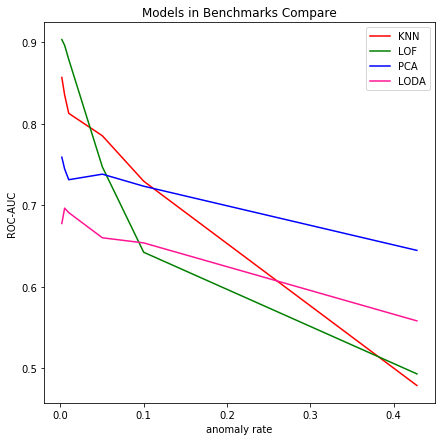

In [106]:
ar_mean.sort()
plt.figure(figsize=(7,7))
plt.xlabel('anomaly rate')
plt.ylabel('ROC-AUC')
colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
i = 0
for cls in classifiers:
    mean_y = [np.mean(results[cls][120:240]), np.mean(results[cls][240:360]), np.mean(results[cls][360:480]), 
              np.mean(results[cls][480:600]), np.mean(results[cls][600:720]), np.mean(results[cls][:120])]    
    plt.plot(ar_mean, mean_y, color=colors[i], label=cls)
    i += 1
plt.title('Models in Benchmarks Compare')
plt.legend(loc="upper right")
plt.show()

### 可以看到，所有算法在高异常点比例下表现均较差，在低异常点比例下表现较好。其中，KNN和LOF在不同异常点下的差异最为明显，低异常点下表现最好，高异常点下基本表现最差。相反，PCA在不同异常点比例下表现较为鲁棒。
### 因此可以得出结论，Proximity-Based(KNN，LOF)的方法对异常点比例较为敏感，Linear Model(PCA)和Outlier Ensembles(LODA)方法较为鲁棒。这也符合基本常识。